Dependencies:
```
- torch
- matplotlib
- pandas
- seaborn
- scikit-learn
- numpy
- tqdm
- jupyterlab
- scipy
- scanpy
- glmpca
```


In [6]:
import sys
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch

import sys
from importlib import reload

sys.path.append('src')
import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts
# from gaston.run_slurm_scripts import train_NN_parallel
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

import seaborn as sns
import math

# Pre-processing

GASTON requires: 
- N x G counts matrix
- N x 2 spatial coordinate matrix,
- list of names for each gene

where N=number of spatial locations and G=number of genes

We run GLMPCA to compute the top PCs (one could use PCA instead but the factors often look worse)

In [2]:
!mkdir -p tutorial_outputs

In [3]:
# INSERT DATA HERE

counts_mat=np.load('data/cerebellum/cerebellum_counts_mat.npy')
coords_mat=np.load('data/cerebellum/cerebellum_coords_mat.npy')
gene_labels=np.load('data/cerebellum/cerebellum_gene_labels.npy', allow_pickle=True)

In [5]:
# RUN GLMPCA

num_dims=8 #2 * number of clusters
penalty=10 # may need to increase if this is too small

glmpca_res=glmpca.glmpca(counts_mat, num_dims, fam="poi", penalty=penalty, verbose=True)
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

np.save('tutorial_outputs/glmpca.npy', A)

Iteration: 0 | deviance=2.4128E+7



KeyboardInterrupt



In [ ]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'GLM-PC{i}')

# Train GASTON neural network

We include how to train the neural network with two options: (1) a command line script and (2) in a notebook. We typically train the neural network 30 different times, each with a different seed, and we use the NN with lowest loss. 

## Option 1: Slurm (Recommended)

For option (1), the code below creates 30 different Slurm jobs, one for each initialization. To train the NN for a single initialization run the following command:

`gaston -i /path/to/coords.npy -o /path/to/glmpca.npy -d /path/to/output_dir -e 10000 -c 500 -p 20 20 -x 20 20 -z adam -s SEED`

for a given `SEED` value (integer)

In [4]:
# TO CHANGE: DATA AND NEURAL NET PARAMETERS (USER CAN CHANGE)
path_to_coords='data/cerebellum/cerebellum_coords_mat.npy'
path_to_glmpca='data/cerebellum/F_glmpca_penalty_10_rep1.npy' # for the GLM-PCs from paper
# path_to_glmpca='tutorial_outputs/glmpca.npy' # GLM-PCA results from above

# [20,20] means 
isodepth_arch=[20,20] # architecture (two hidden layers of size 20) for isodepth neural network d(x,y)
expression_arch=[20,20] # architecture (two hidden layers of size 20) for 1-D expression function
epochs = 10000 # number of epochs to train NN
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
optimizer = "adam"
num_restarts=30 # number of initializations

output_dir='tutorial_outputs' # folder to save model runs
conda_environment='gaston-package'
path_to_conda_folder='/n/fs/ragr-data/users/uchitra/miniconda3/bin/activate'

run_slurm_scripts.train_NN_parallel(path_to_coords, path_to_glmpca, isodepth_arch, expression_arch, 
                      output_dir, conda_environment, path_to_conda_folder,
                      epochs=epochs, checkpoint=checkpoint, 
                      num_seeds=num_restarts)

jobId: 19647225
jobId: 19647226
jobId: 19647227
jobId: 19647228
jobId: 19647229
jobId: 19647230
jobId: 19647231
jobId: 19647232
jobId: 19647233
jobId: 19647234
jobId: 19647235
jobId: 19647236
jobId: 19647237
jobId: 19647238
jobId: 19647239
jobId: 19647240
jobId: 19647241
jobId: 19647242
jobId: 19647243
jobId: 19647244
jobId: 19647245
jobId: 19647246
jobId: 19647247
jobId: 19647248
jobId: 19647249
jobId: 19647250
jobId: 19647251
jobId: 19647252
jobId: 19647253
jobId: 19647254


Wait for models to finish training. You can check on their status by running `squeue -u uchitra`  -- replacing `uchitra` with your username

## Option 2: train in notebook

We first load GLM-PCs and coordinates and z-score normalize.

In [289]:
# Load N x G matrix A of GLM-PCs, and N x 2 matrix S
# A=np.load('tutorial_outputs/glmpca.npy') # GLM-PCA results from above
A=np.load('data/cerebellum/F_glmpca_penalty_10_rep1.npy') # GLM-PCA results used in manuscript
S=coords_mat

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

Next we train the neural network, once for each random initialization.

In [260]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='tutorial_outputs' # folder to save model runs
optimizer = "adam"
num_restarts=30

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=[20,20], A_hidden_list=[20,20], 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

training neural network for seed 19


# Process neural network output

The figures below closely match the manuscript --- but do not exactly match --- due to PyTorch non-determinism in seeding: see https://github.com/pytorch/pytorch/issues/7068

## Visualize isodepth (topographic map) and spatial domains

Load best model

In [7]:
mod, A, S= process_NN_output.process_files('tutorial_outputs')

# MODEL TO MATCH PAPER FIGURES
# mod, A, S= process_NN_output.process_files('reproduce_cerebellum')

best model: tutorial_outputs/seed19


Compute isodepth and gaston labels from model

In [8]:
num_layers=4
gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(mod,A,S,num_layers)

# DATASET-SPECIFIC
gaston_isodepth=np.max(gaston_isodepth) - gaston_isodepth
gaston_labels=(num_layers-1)-gaston_labels # domains are ordered from oligodendrocyte to molecular

OPTIONAL: Scale isodepth to approximately reflect physical distances

In [9]:
# NOTE:  q_vals=[0.2, 0.05, 0.15, 0.3] was manually chosen for the cerebellum 
# you may omit the argument for other datasets (automatically uses 0.05)

# WITH VISUALIZATION
# gaston_isodepth=isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, num_layers, coords_mat, 
#                                  q_vals=[0.2, 0.05, 0.15, 0.3], visualize=True, figsize=(12,12),num_rows=2)

# WITHOUT
gaston_isodepth=isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, num_layers, coords_mat, 
                                 q_vals=[0.2, 0.05, 0.15, 0.3])

Topographic map of isodepth + contours

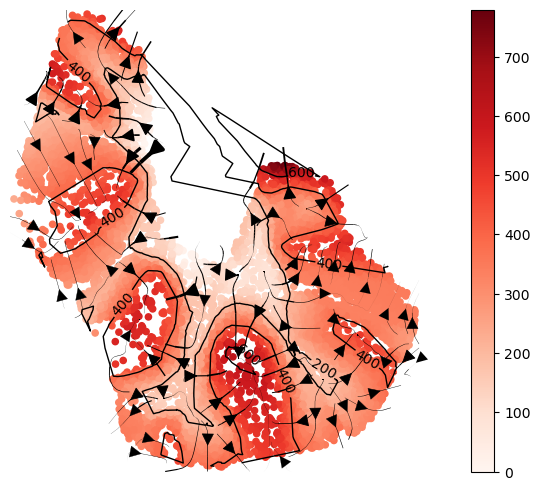

In [11]:
show_streamlines=True
cluster_plotting.plot_isodepth(gaston_isodepth, S, mod, figsize=(7,6), streamlines=show_streamlines)

Spatial domains

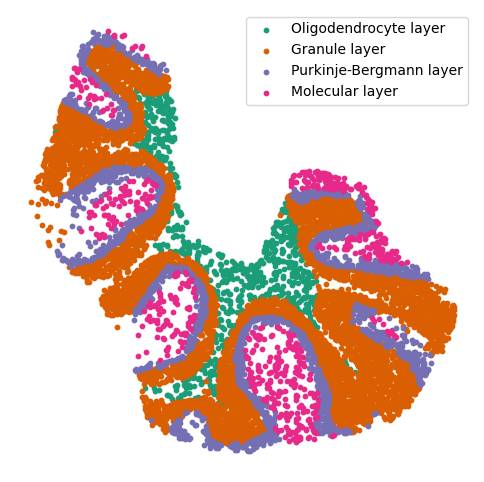

In [394]:
labels=['Oligodendrocyte layer', 'Granule layer', 'Purkinje-Bergmann layer', 'Molecular layer']

# WITHOUT CUSTOM COLORS
cluster_plotting.plot_clusters(gaston_labels, A, S, figsize=(6,6), colors=None, 
                               color_palette=plt.cm.Dark2, s=10,labels=labels,lgd=True)

# TO PLOT WITH CUSTOM COLORS:
# domain_colors=['C6', 'mediumseagreen', 'darkmagenta', 'C8']
# cluster_plotting.plot_clusters(gaston_labels, A, S, figsize=(6,6), colors=domain_colors, s=20,labels=labels,lgd=True)

## Plot cell type vs isodepth (if cell type info available)

Load cell type label per spot (from RCTD). We store as N x C dataframe M where M[i,c]=1 if spot i is cell type c, and 0 if not

In [12]:
cell_type_df=pd.read_csv('data/cerebellum/cell_type_df.csv', index_col=0)
cell_type_df

,Astrocytes,Bergmann,Candelabrum,Choroid,Endothelial,Ependymal,Fibroblast,Globular,Golgi,Granule,Lugaro,MLI1,MLI2,Macrophages,Microglia,Oligodendrocytes,Polydendrocytes,Purkinje,UBCs
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9983,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0


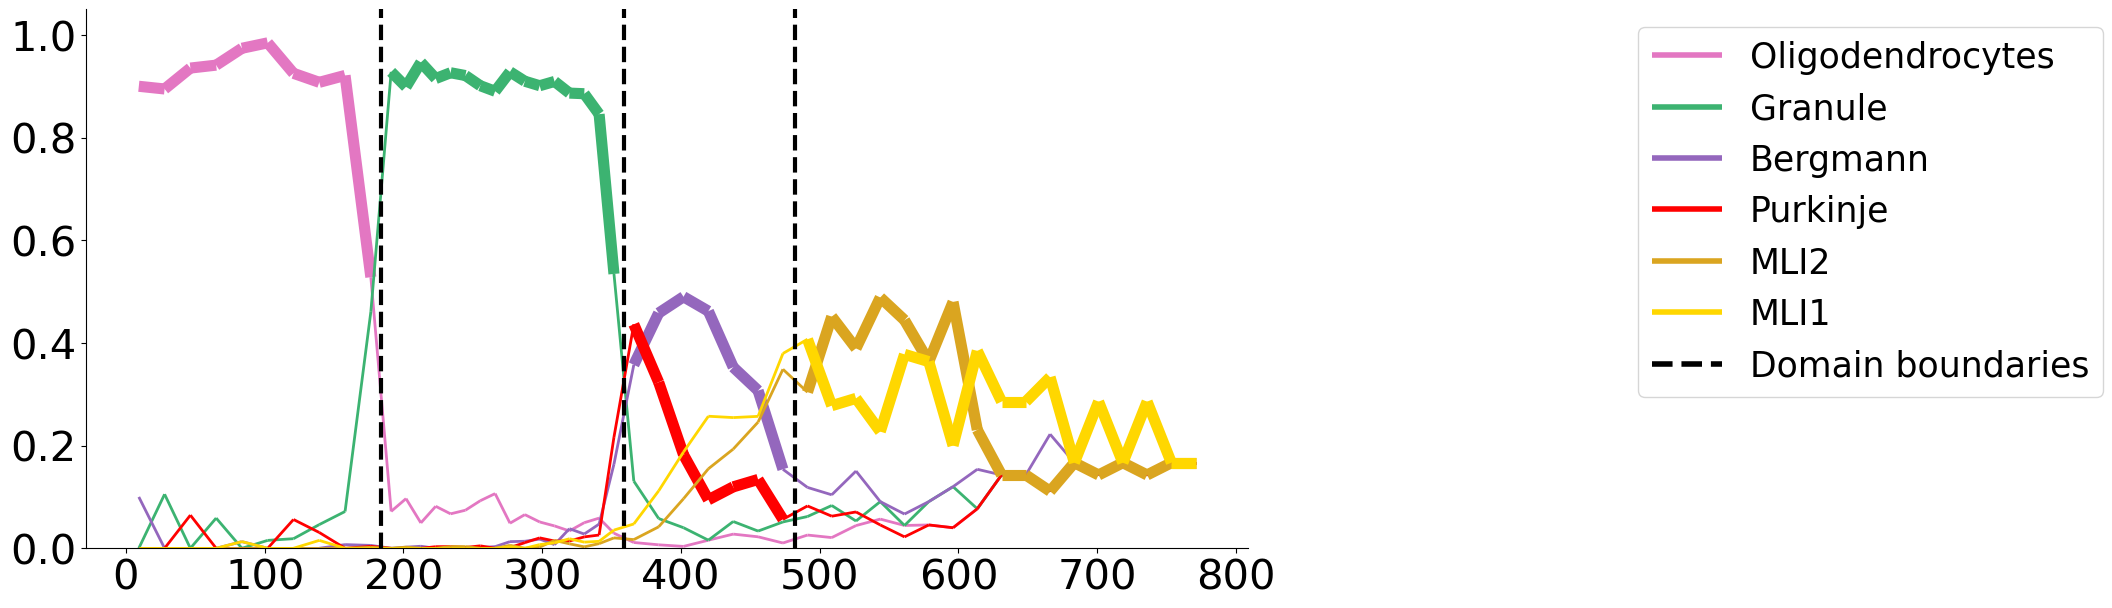

In [13]:
ct_colors={'Oligodendrocytes': 'C6', 'Granule': 'mediumseagreen', 'Purkinje': 'red', 
           'Bergmann': 'C4', 'MLI1': 'gold', 'MLI2': 'goldenrod',  'Astrocytes': 'C0', 
           'Golgi': 'C9', 'Fibroblast': 'C5'}


plot_cell_types.plot_ct_props(cell_type_df, gaston_labels, gaston_isodepth, 
                              num_bins_per_domain=[10,16,7,17], ct_colors=ct_colors, ct_pseudocounts={3:1}, 
                              include_lgd=True, figsize=(15,7), ticksize=30, width1=8, width2=2, 
                              domain_ct_threshold=0.5)

## Spatially varying gene analysis

In [17]:
domain_colors=['C6', 'mediumseagreen', 'darkmagenta', 'C8'] # layers: oligodendrocyte, granule, P-B, mol layers

ct_colors={'Oligodendrocytes': 'C6', 'Granule': 'mediumseagreen', 'Purkinje': 'red', 
           'Bergmann': 'C4', 'MLI1': 'gold', 'MLI2': 'goldenrod',  'Astrocytes': 'C0', 
           'Golgi': 'C9', 'Fibroblast': 'C5'}

# if you want to get rid of warnings
import warnings
warnings.filterwarnings("ignore")

Compute piecewise linear fit for every gene 

In [18]:
ct_list=['Oligodendrocytes', 'Granule', 'Bergmann', 'Purkinje', 'MLI1', 'MLI2']

t=0.1 # threshold p-values at 0.1
umi_threshold=500 # only compute fit for genes with total UMI > 500
zero_fit_threshold=75 # only compute fit for (gene, domain) where gene has at least 75 UMIs in domain
pw_fit_dict=segmented_fit.pw_linear_fit(counts_mat, gaston_labels, gaston_isodepth, 
                                          cell_type_df, ct_list, zero_fit_threshold=zero_fit_threshold,
                                        t=t,umi_threshold=umi_threshold,
                                       isodepth_mult_factor=0.1) 
# isodepth_mult_factor for stability, if range of isodepth values is too large

Poisson regression for ALL cell types


100%|██████████| 2193/2193 [01:02<00:00, 34.97it/s]


Poisson regression for cell type: Oligodendrocytes


100%|██████████| 2193/2193 [00:41<00:00, 52.69it/s]


Poisson regression for cell type: Granule


100%|██████████| 2193/2193 [00:59<00:00, 37.02it/s]


Poisson regression for cell type: Bergmann


100%|██████████| 2193/2193 [00:41<00:00, 52.31it/s]


Poisson regression for cell type: Purkinje


100%|██████████| 2193/2193 [00:38<00:00, 56.35it/s]


Poisson regression for cell type: MLI1


100%|██████████| 2193/2193 [00:44<00:00, 49.68it/s]


Poisson regression for cell type: MLI2


100%|██████████| 2193/2193 [00:44<00:00, 49.04it/s]


In [19]:
binning_output=binning_and_plotting.bin_data(counts_mat, gaston_labels, gaston_isodepth, 
                         cell_type_df, gene_labels, num_bins_per_domain=[5,10,5,5], umi_threshold=umi_threshold)

Find discontinuous and continuous genes and visualize piecewise linear fits 

In [45]:
q=0.9 # use 0.9 quantile for slopes, discontinuities
discont_genes_layer=spatial_gene_classification.get_discont_genes(pw_fit_dict, binning_output,q=q)
cont_genes_layer=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,q=q)

[1] [1]


(1.0, 7.5)

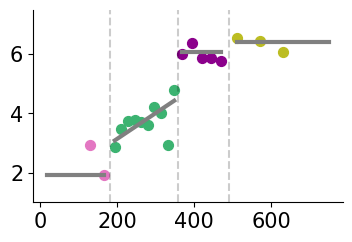

In [46]:
gene_name='Frmpd4'
print(discont_genes_layer[gene_name],cont_genes_layer[gene_name])

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
                                       domain_boundary_plotting=True)
plt.ylim((1,7.5))

[] [1]


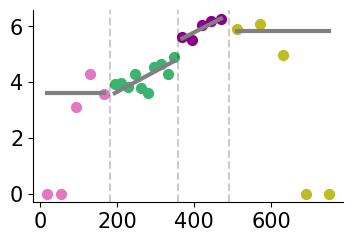

In [47]:
gene_name='Sbk1'
print(discont_genes_layer[gene_name],cont_genes_layer[gene_name])

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
                                       domain_boundary_plotting=True)
# plt.ylim((1,7.5))

 Cell type-attributable and other intradomain variation

In [48]:
domain_cts=plot_cell_types.get_domain_cts(binning_output, 0.5) # layer-specific cell types
cont_genes_layer_ct=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,
                                                               ct_attributable=True, 
                                                              domain_cts=domain_cts,
                                                               q=0.9,
                                                              ct_perc=0.4)

[(1, 'Granule'), (2, 'Bergmann')]


Text(0.5, 1.0, 'Granule only')

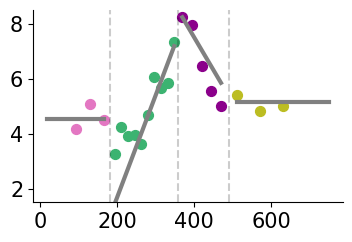

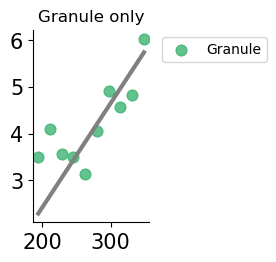

In [77]:
gene_name='Calb1'
print(cont_genes_layer_ct[gene_name])

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
                                       domain_boundary_plotting=True)
plt.ylim((1.5,8.5))

# show cell type-specific functions in domain 1 (granule)

domain=1
cts=domain_cts[domain]

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output,
                                        cell_type_list=cts,ct_colors=ct_colors, spot_threshold=0.2, pt_size=60, 
                                        colors=domain_colors, linear_fit=True, domain_list=[domain],ticksize=15, 
                                        figsize=(1.5,2.5), offset=10**6, lw=3, alpha=0.8,show_lgd=True)
cts_list=' '.join(map(str, cts))
plt.title(f'{cts_list} only')

[(0, 'Other'), (3, 'Other')]


Text(0.5, 1.0, 'MLI2 MLI1 only')

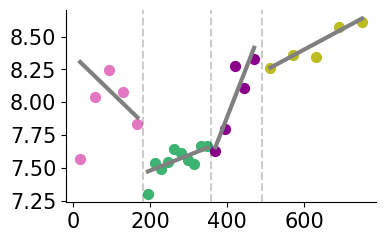

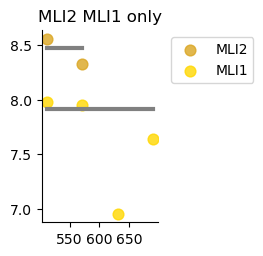

In [76]:
reload(binning_and_plotting)

gene_name='Camk1d'
print(cont_genes_layer_ct[gene_name])

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
                                       domain_boundary_plotting=True)

# show cell type-specific functions in domain 3 (MLI)

domain=3
cts=domain_cts[domain]

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output,
                                        cell_type_list=cts,ct_colors=ct_colors, spot_threshold=0.2, pt_size=60, 
                                        colors=domain_colors, linear_fit=True, domain_list=[domain],ticksize=10, 
                                        figsize=(1.5,2.5), offset=10**6, lw=3, alpha=0.8, show_lgd=True)
cts_list=' '.join(map(str, cts))
plt.title(f'{cts_list} only')